# Understanding Attrition and Engagement
**Goal:** This analysis will use logistic regressiona and random forest to provide insights on:
1. What is driving attrition and who is most likely to leave
2. What is driving employee engagement

**Data:** This analysis uses an HR dataset created by IBM data scientists. The data can be found on Kaggle [here](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset).

## Import Libraries

In [122]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)  

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline


## Data Preview
We're working with 1470 observations and 35 columns. A review of the data within Kaggle suggests our data is quite clean; but we'll preview the data below.

Initial observations:
* There does not appear to be any missing data or duplicate employee IDs
* All columns appear to have appropriate initial data types
* All numeric columns appear to have reasonable values (no inherently improbably mins/maxs)
* The Attrition column is our first outcome of interest
    * 16% of employees in the dataset turned over (moderate imbalance, unsurprising)
* The Job Satisfaction column is our second outcome of interest
    * mean = 2.7, sd = 1.1
* Other notable attributes:
    * Most employees never travel (71%)
    * Most employees work in R&D (65%) following by Sales (30%)
    * Most employees come from the Life Sciences or Medical fields (73%)
    * 60% of employees are male
    * Mean age = 36.9 years, sd = 9.1
    * Mean tenure = 7.0 years, sd = 6.1

In [5]:
hr_dat = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr_dat.shape

(1470, 35)

In [149]:
hr_dat.info()
hr_dat.head()
hr_dat['EmployeeNumber'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


1470

In [11]:
hr_dat.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


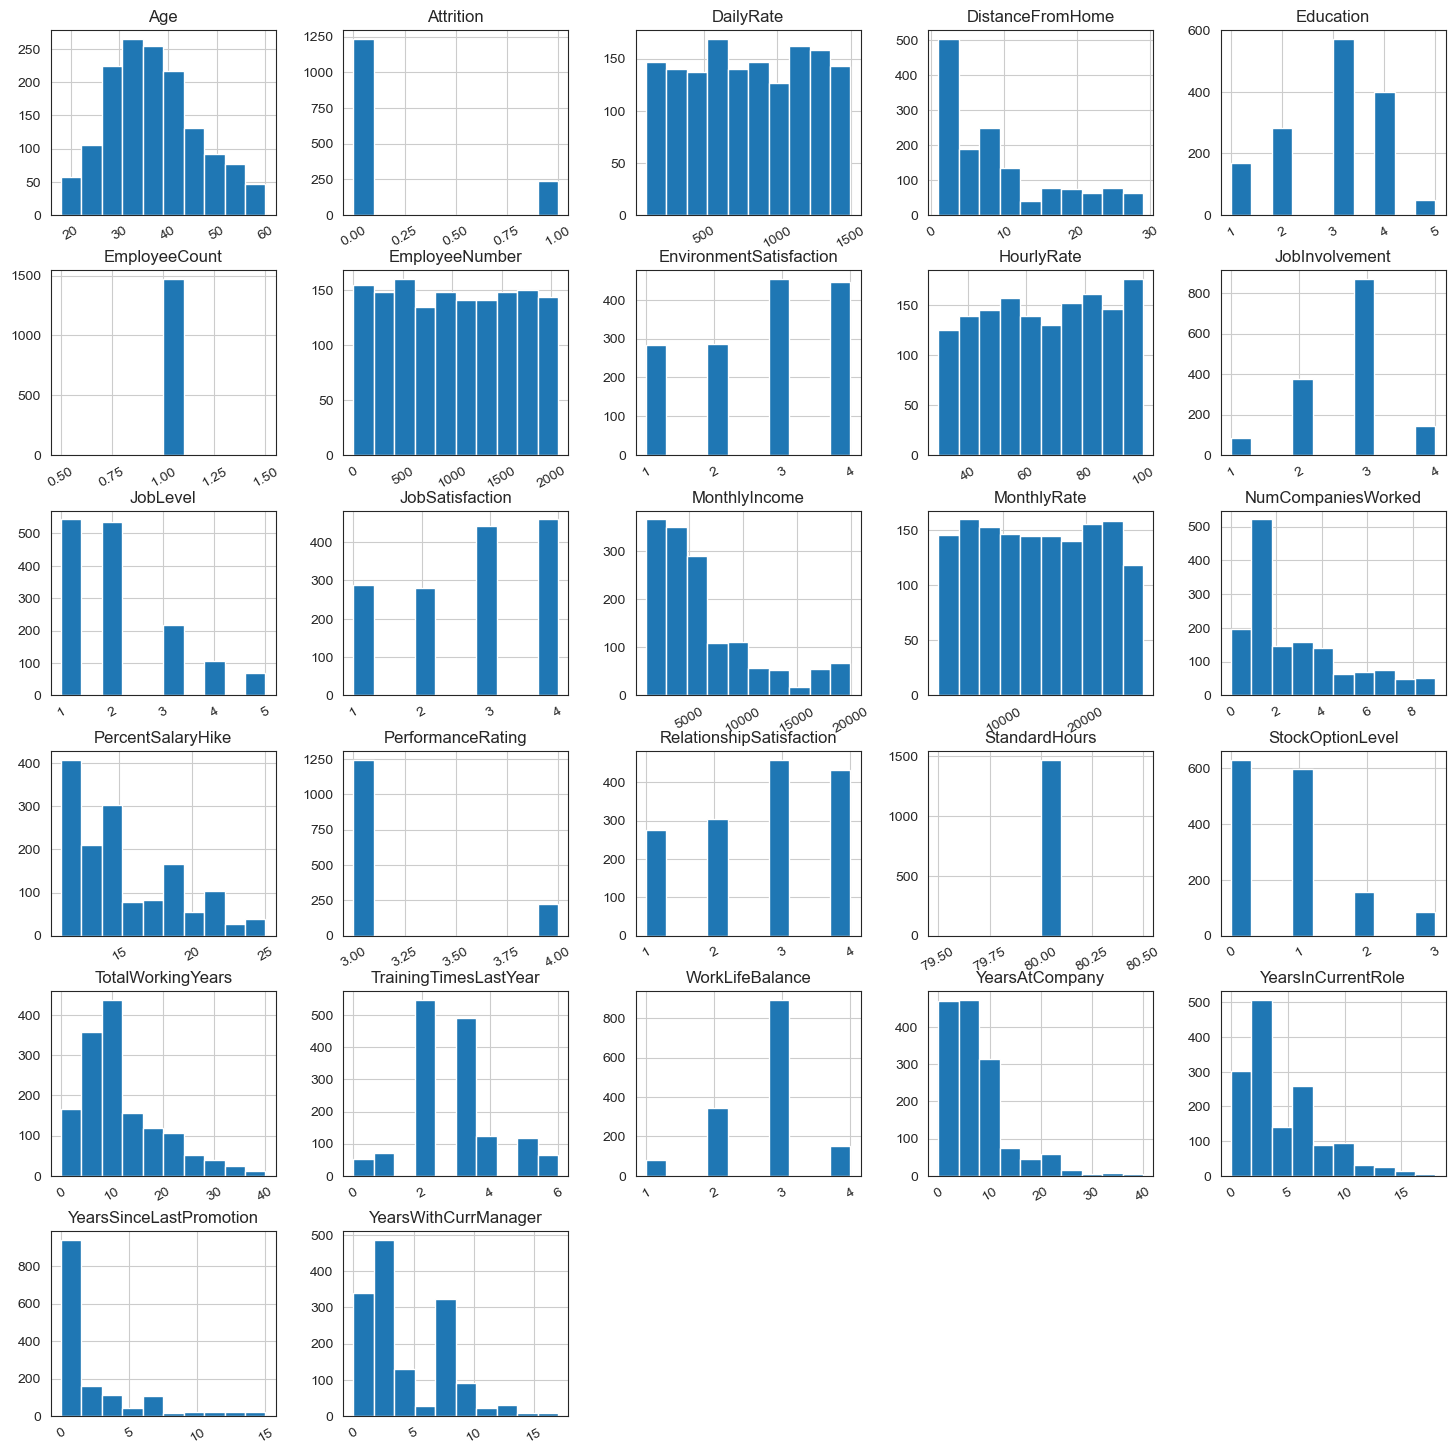

In [95]:
hr_dat.hist(figsize=(18,18), xrot=30)
plt.show();

In [38]:
#review categorical columns
cat_cols = hr_dat.select_dtypes(include=['object']).columns

for c in cat_cols:
    hr_dat[c].value_counts(normalize = True)

Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: BusinessTravel, dtype: float64

Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: Department, dtype: float64

Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: EducationField, dtype: float64

Male      0.6
Female    0.4
Name: Gender, dtype: float64

Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manager                      0.069388
Sales Representative         0.056463
Research Director            0.054422
Human Resources              0.035374
Name: JobRole, dtype: float64

Married     0.457823
Single      0.319728
Divorced    0.222449
Name: MaritalStatus, dtype: float64

Y    1.0
Name: Over18, dtype: float64

No     0.717007
Yes    0.282993
Name: OverTime, dtype: float64

From here, we can drop some unnecessary columns:
* EmployeeCount - All 1s
* EmployeeNumber - Unique identifier
* StandardHours - All 80

In [93]:
hr_clean = hr_dat.drop(columns=['EmployeeCount','EmployeeNumber','StandardHours'], axis=1)

# Analysis 1: Attrition
Let's discover what is driving attrition and what features may best predict attrition.

## Exploratory Data Analysis


In [15]:
#Recode attrition column to 1/0
hr_clean['Attrition'] = hr_clean['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_clean['Attrition'].value_counts(normalize=True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

### Distrubtion of Attrition by Categorical Columns


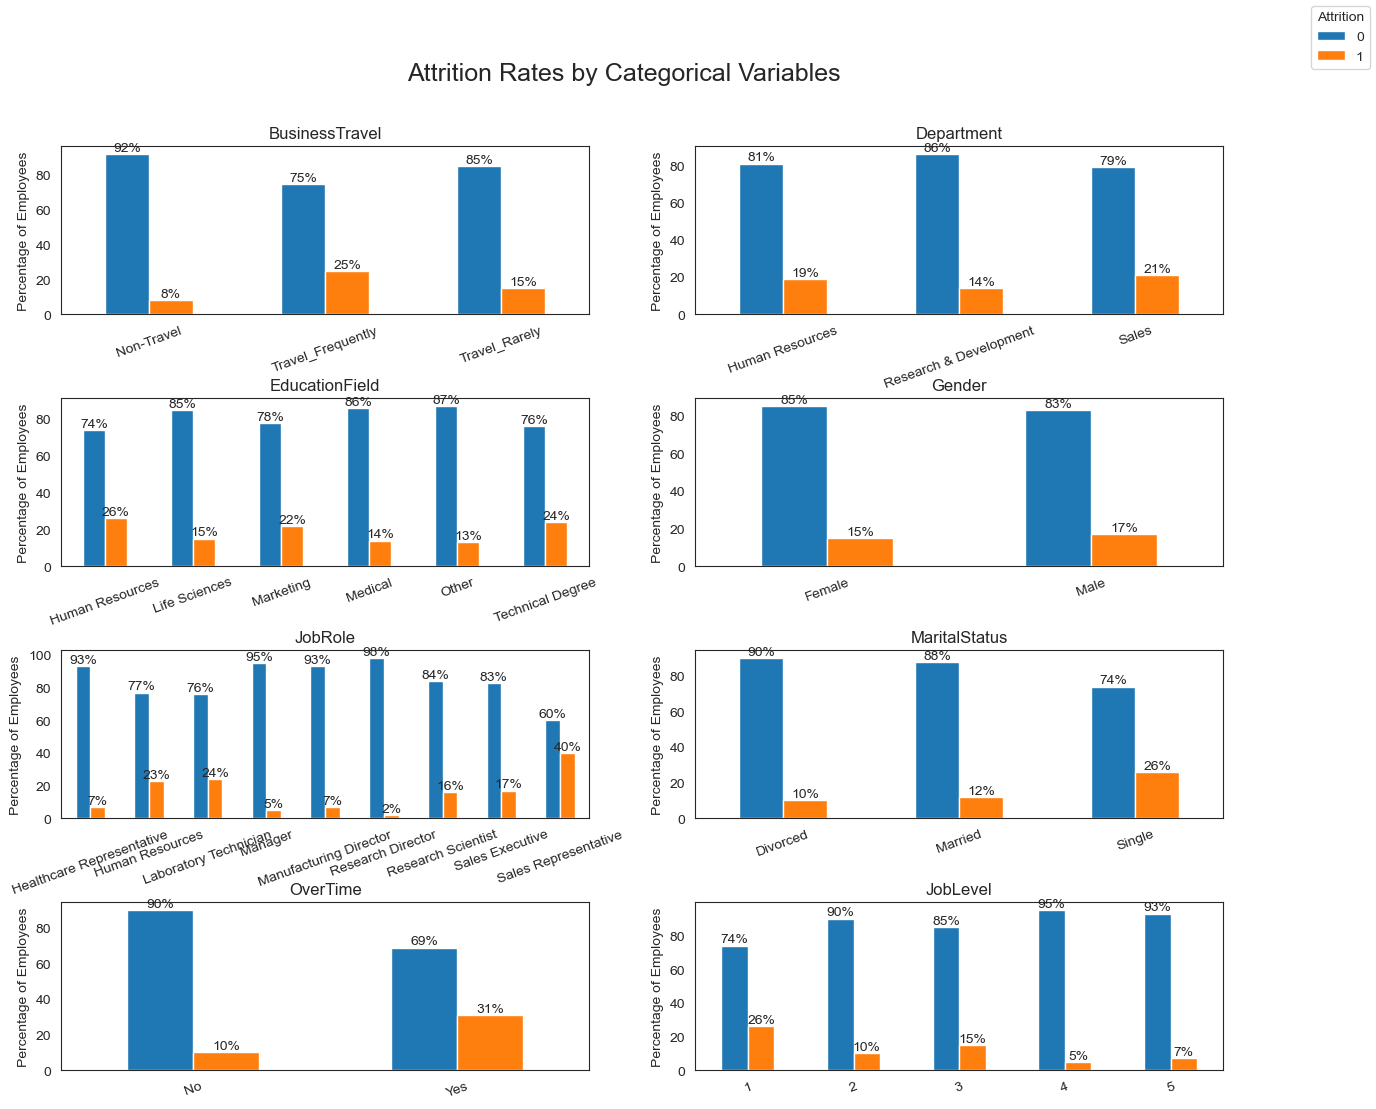

In [128]:
target_cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'JobLevel']

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Categorical Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(target_cat_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

Observations:
* R&D make up the majority of employees, buth they have lower attrition than HR and Sales. This trend is further illustrated when viewing attrition by Job Role and Education Field.
    * Overtime and frequent travel do not vary significantly between departments.
* Attrition is similar for males and females.
* Attrition is heightened for employees working overtime, traveling frequently, for single employees, and entry level employees. 
    * Overtime, travel, and department breakdowns are similar for each marital status.
    * It's possible that single individuals have more flexibility to changes jobs, or perhaps there are other covariates that explain the higher attrition rate that we haven't looked at yet. (ex. correlation with age?)

Takeaways:
* Overtime, Travel, and Department may elicit insights on attrition trends. Marital status is curious, but would take some additional investigation to determine its practical significance.

### Distribution of Attrition by Engagement-Related Metrics

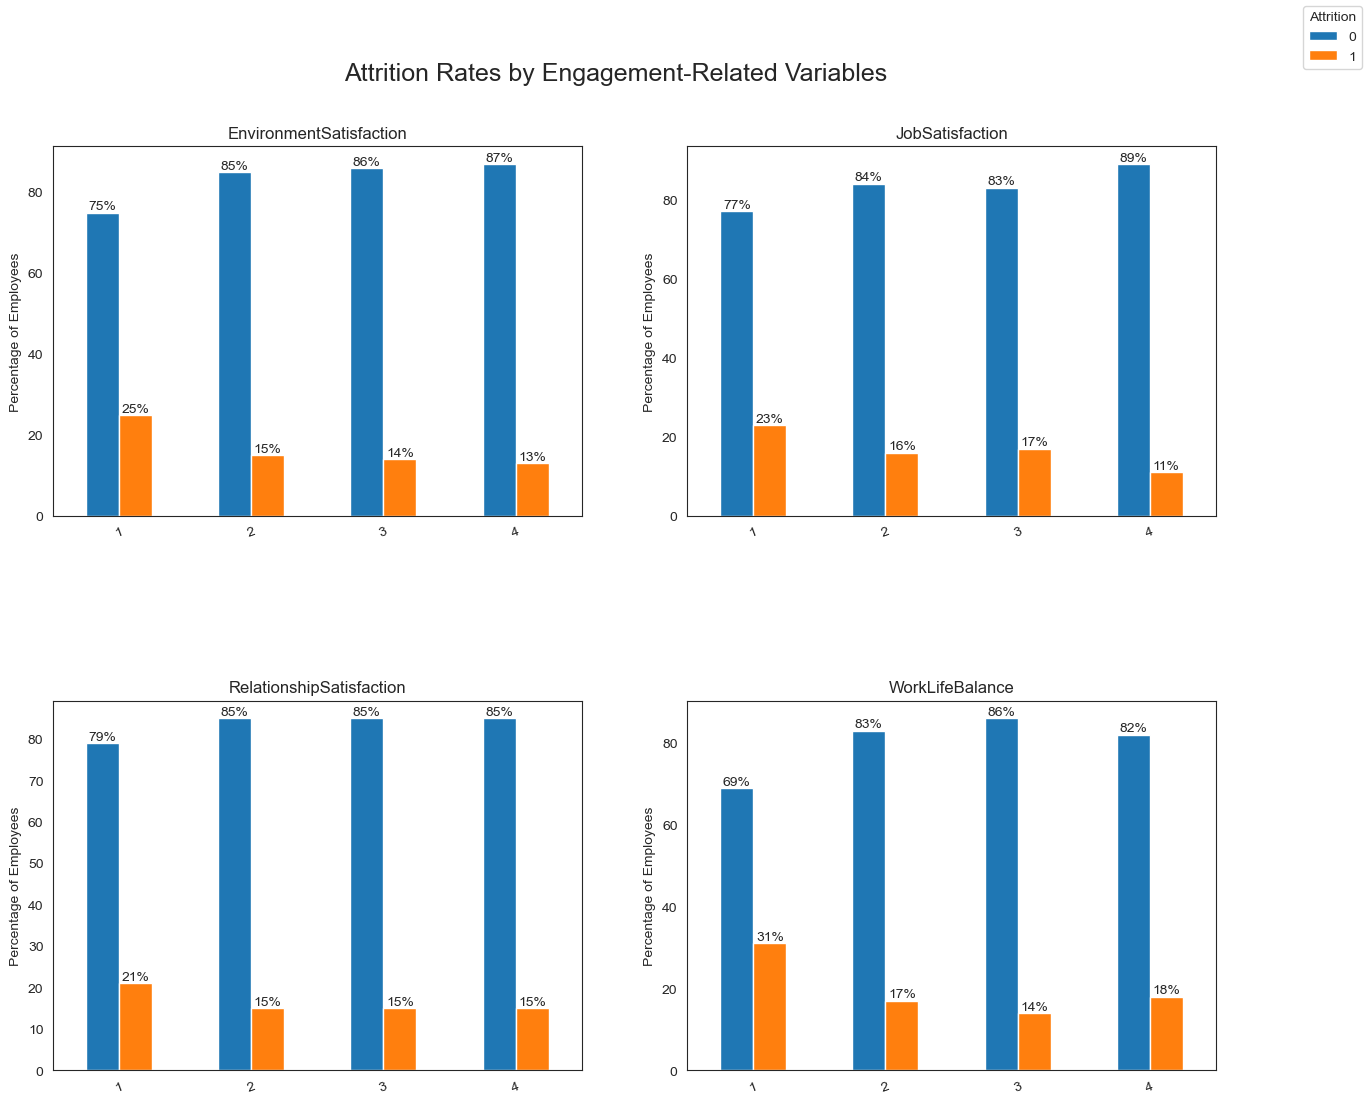

In [108]:
eng_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Engagement-Related Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(eng_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

In [ ]:
### Engagement Metrics x Job Role

In [154]:
deptEng = hr_clean.groupby(['Department', 'Attrition'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()
deptEng

,Department,Attrition,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,Human Resources,0,2.705882,2.921569,2.764706,2.843137
1,Human Resources,1,2.166667,2.916667,2.333333,3.083333
2,Research & Development,0,2.769324,2.748792,2.787440,2.739130
3,Research & Development,1,2.458647,2.578947,2.473684,2.518797
4,Sales,0,2.810734,2.836158,2.734463,2.706215
5,Sales,1,2.521739,2.739130,2.467391,2.652174


### Correlation Matrix


In [109]:
#Grab dummies for cat vars of interest
hr_dummies = pd.get_dummies(hr_clean, columns=['BusinessTravel', 'OverTime','Department', 'MaritalStatus', 'JobRole'], drop_first=True)

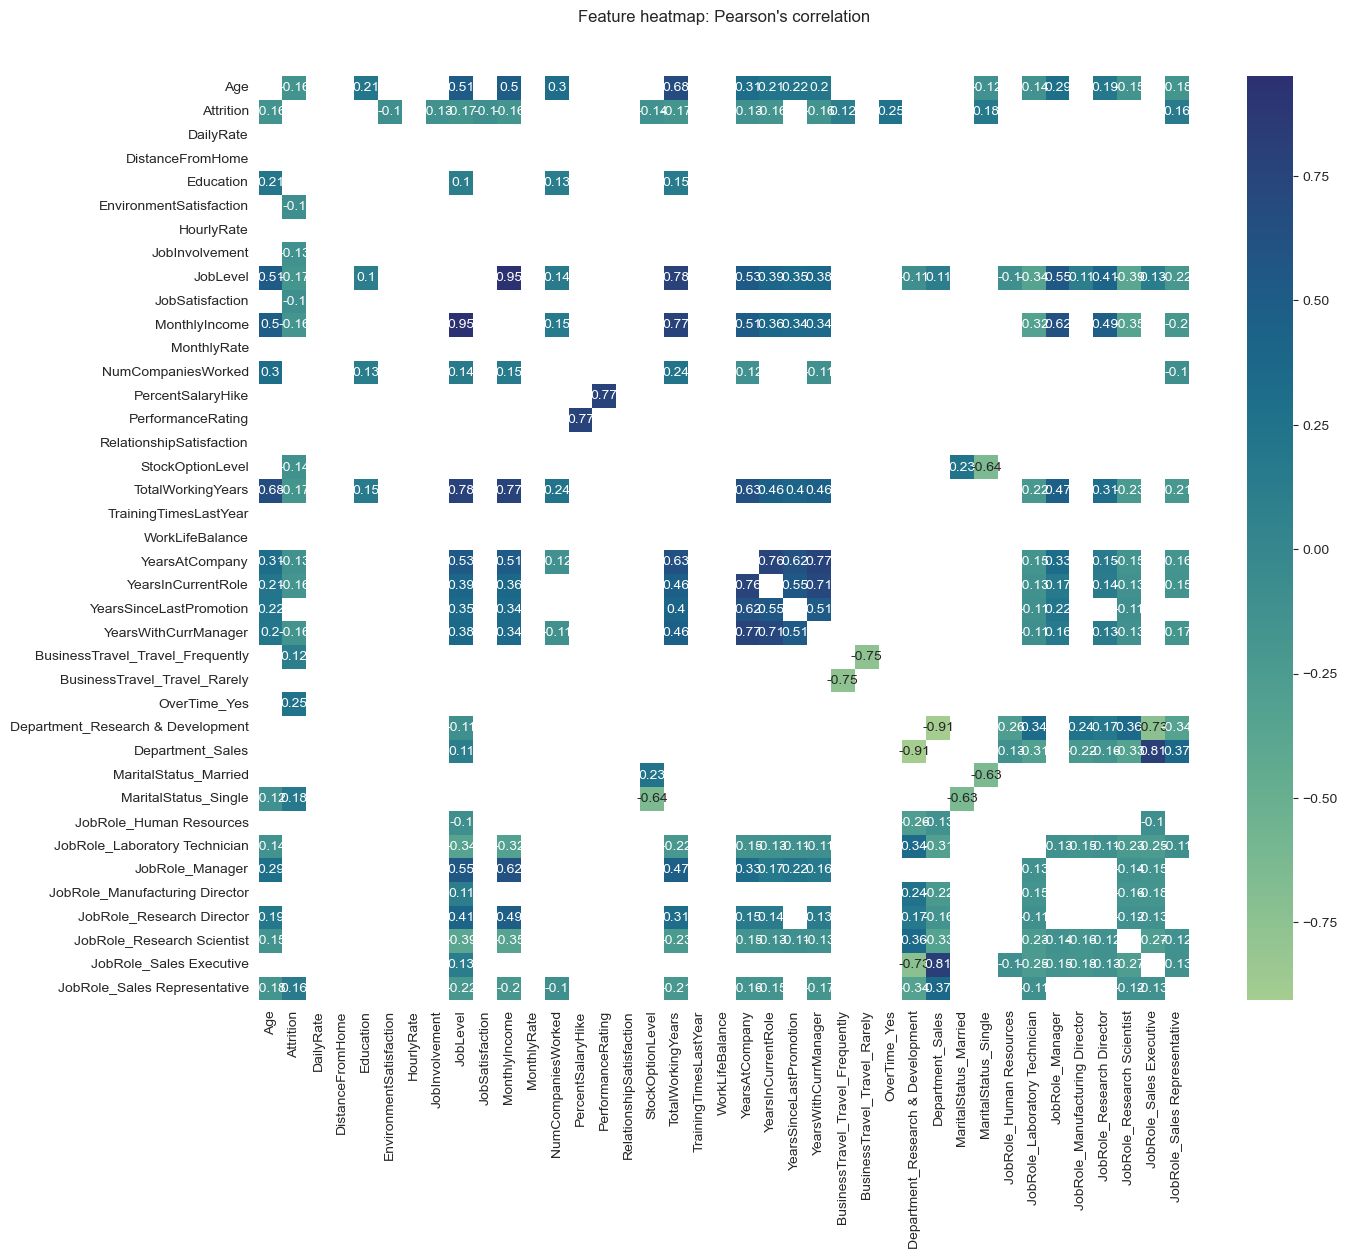

In [110]:
#create pearson correlation heatmap of features
corrs = hr_dummies.corr()

#only show corrs between .2 and 1 for readability (corr = 1 is just self correlation)
plt.figure(figsize=(15,12))
sns.heatmap(corrs[((corrs>0.1)&(corrs<1)) | (corrs < -.1)], cmap='crest', annot=True)
plt.title("Feature heatmap: Pearson's correlation", y = 1.05);

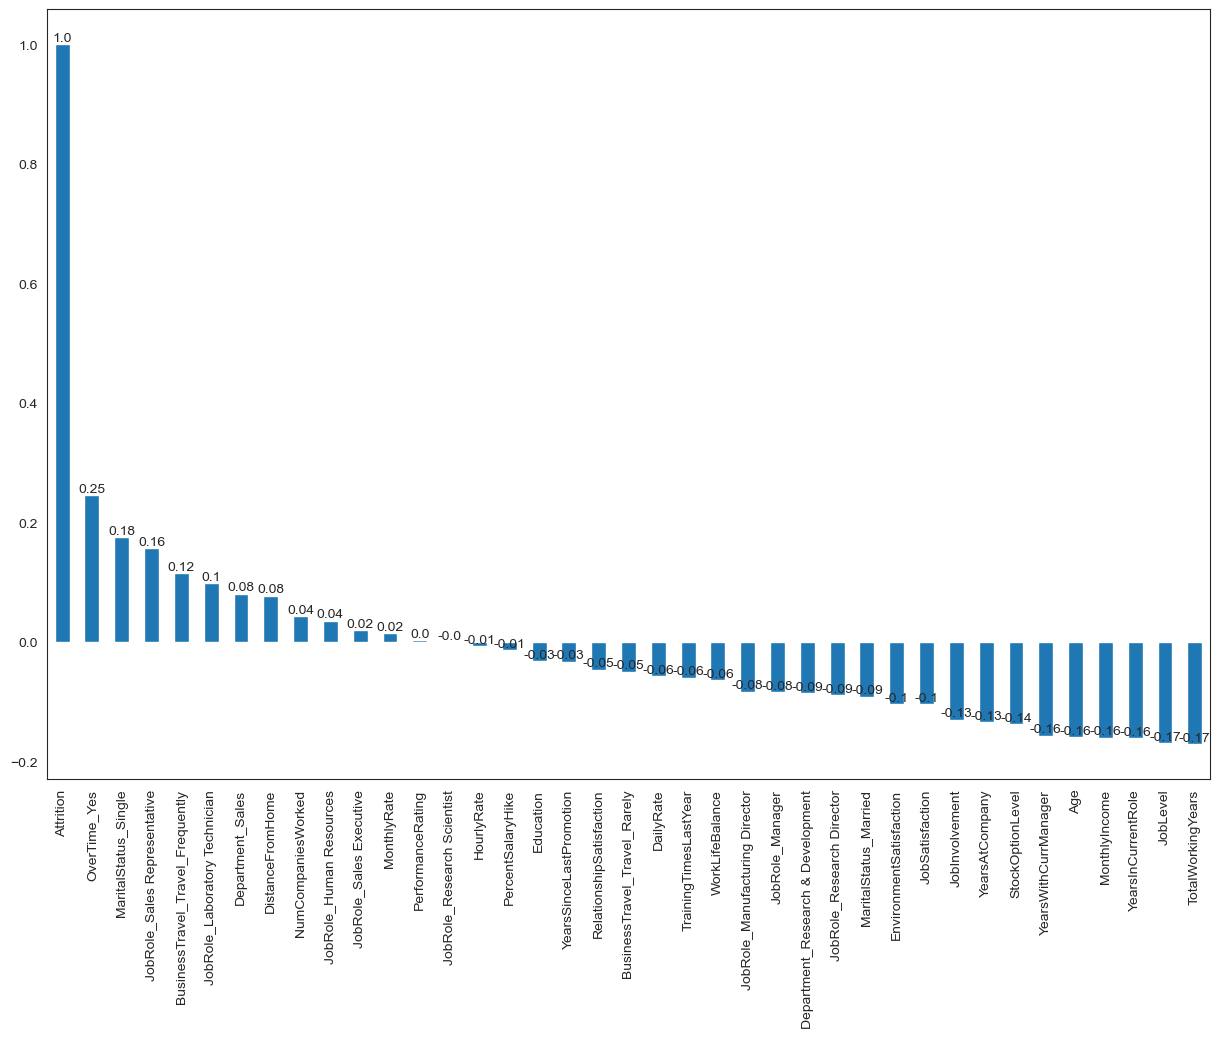

In [114]:
#Let's get a better view of what correlates with attrition
plt.figure(figsize=(15,10))
corplot = corrs['Attrition'].sort_values(ascending = False).plot(kind='bar')
# Add labels to the bars
for i, val in enumerate(corrs['Attrition'].sort_values(ascending=False)):
    corplot.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontsize': 10})
plt.show();


## Feature Selection
I'd like to reduce the number of features to avoid overfitting the model. I will use the following to eliminate features:
1. Include features that domain knowledge suggests might influence attrition (engagement-related metrics)
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* Job Satisfaction
2. Include features with stronger correlations with attrition but are also actionable/insightful; eliminate features that are highly intercorrelated
* Overtime_Yes
* JobRole_SalesRep
* BusinessTravel_Frequently
* JobRole_Lab_Tech
* YearsInCurrRole
* JobLevel
* MonthlyIncome




In [129]:
hr_final = hr_dummies[['Attrition','RelationshipSatisfaction','WorkLifeBalance',
'JobSatisfaction', 'OverTime_Yes','MaritalStatus_Single','JobRole_Sales Representative', 
'BusinessTravel_Travel_Frequently', 'JobRole_Laboratory Technician','YearsInCurrentRole','JobLevel',
'MonthlyIncome']]

In [145]:
hr_final = hr_dummies

In [146]:
X = hr_final.drop('Attrition', axis = 1)
y = hr_final['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1176, 41)
(294, 41)
(1176,)
(294,)


In [147]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty="l2", #help prevent overfitting
                                      class_weight={0:1,1:2}, #help w/ the imbalance
                                      solver = 'liblinear',
                                      max_iter=10000))
])

pipe.fit(X_train, y_train)
pipe.named_steps['classifier'].get_params()

ValueError: could not convert string to float: 'Technical Degree'

In [143]:
pred = pipe.predict(X_test)

In [144]:
acc_score=accuracy_score(pred, y_test)
print(acc_score)

0.7959183673469388


In [127]:
report=classification_report(pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       277
           1       0.15      0.35      0.21        17

    accuracy                           0.85       294
   macro avg       0.56      0.62      0.57       294
weighted avg       0.91      0.85      0.88       294

